In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
!pip install pyspark
!pip install h2o
!pip install TPOT
!pip install autokeras
!pip install autopytorch
!pip install autoPyTorch[forecasting]
!pip install auto-sklearn

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
import os
import pandas as pd

# Reading preprocessed dataset and scaling dictionary
data_directory_path = os.getcwd()
df_scaled = pd.read_csv(os.path.join(data_directory_path, "Data", "scaled_wind_data.csv")) 
scaling_dict_df = pd.read_csv(os.path.join(data_directory_path, "Data", "scaling_df.csv"))
scaling_dict = scaling_dict_df.to_dict()

# Dividing into train, validation and testing
train_set, val_test_set= np.split(df_scaled, [int(.80 *len(df_scaled))])
val_set, test_set= np.split(val_test_set, [int(.50 *len(val_test_set))])

#Preparing X data
data_x_train = train_set.drop(columns=["timestamp"]).astype("float64").drop(columns=["label"])
data_x_val = val_set.drop(columns=["timestamp"]).astype("float64").drop(columns=["label"])
data_x_test = test_set.drop(columns=["timestamp"]).astype("float64").drop(columns=["label"])

#Preparing Y data
data_y_train = train_set["label"].astype("float64")
data_y_val = val_set["label"].astype("float64")
data_y_test = test_set["label"].astype("float64")

## PySpark GBTRegressor

In [6]:
import pyspark
from pyspark.sql import SparkSession

spark_session = SparkSession.builder.appName("wind_turbine_project").getOrCreate()

In [7]:
from pyspark.ml.feature import VectorAssembler

def prepare_spark_df(spark_df_input, features_to_transform):
  """
  :param spark_df_input: input spark df to be transformed with vector assembler
  :param features_to_transform: list of str representing the features to be used
  :return: the VectorAssembler transformed dataframe
  """
  vectorAssembler = VectorAssembler(inputCols = features_to_transform, outputCol = 'features')
  va_df = vectorAssembler.transform(spark_df_input)
  df_spark = va_df.select('features', 'label')
  return df_spark

features_to_transform = ['month', 'day', 'hour', 'minute', 'wind_speed', 'wind_direction']

train_df = spark_session.createDataFrame(train_set) 
valid_df = spark_session.createDataFrame(val_set) 
test_df = spark_session.createDataFrame(test_set)

train_spark = prepare_spark_df(train_df, features_to_transform)
valid_spark = prepare_spark_df(valid_df, features_to_transform)
test_spark = prepare_spark_df(test_df, features_to_transform)

print('Train dataset spark: ', train_spark.count())
print('Valid dataset spark: ', valid_spark.count())
print('Test dataset spark: ', test_spark.count())

Train dataset spark:  37626
Valid dataset spark:  4703
Test dataset spark:  4704


In [16]:
from pyspark.ml.regression import GBTRegressor

# Instantiate the GBTRegressor model
gbt_instance = GBTRegressor(featuresCol='features', labelCol='label')
gbt_instance.setLossType("squared")
#gbt_instance.setMaxIter(100)
# Train the model
gbt_trained_model = gbt_instance.fit(train_spark)

# Prediction generation
gbt_prediction = gbt_trained_model.transform(test_spark)

# Transform it into numpy array
gbt_prediction = np.array(gbt_prediction.select("prediction").rdd.flatMap(lambda x: x).collect())

In [18]:
evaluation_rmse = np.sqrt(mean_squared_error(data_y_test, gbt_prediction))
print(evaluation_rmse)

0.3482275458754182


## XGBOOST

In [20]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# parameter grid
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'num_parallel_tree': [1,2,3],
        'max_depth': [6, 8, 10]
        }
n_param_combination = 30

# Instantiate the XGBoost model
xgb_model = xgb.XGBRegressor()

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=n_param_combination, scoring='neg_root_mean_squared_error', n_jobs=4, verbose=3, random_state=100)

random_search.fit(data_x_train, data_y_train)

# Prediction generation on the best parameter combination model 
# according to the selected scoring metric (RMSE)
xgboost_prediction = random_search.predict(data_x_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


## H2O 3

In [19]:
import h2o
from h2o.automl import H2OAutoML

# Initialize instance
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp15c6l1v6
  JVM stdout: /tmp/tmp15c6l1v6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp15c6l1v6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_mur6ku
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [21]:
wind_train = h2o.H2OFrame(train_set)
wind_valid = h2o.H2OFrame(val_set)
wind_test = h2o.H2OFrame(test_set)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [29]:
h2o_model = H2OAutoML(max_models = 30, seed = 10, verbosity="info")

In [30]:
# Useful variables
y = 'label'
x = wind_train.columns

# Model Training
h2o_model.train(x = x, y = y, training_frame = wind_train, validation_frame = wind_valid)

leaderboard = h2o_model.leaderboard

# Prediction generation
h2o_prediction = h2o_model.leader.predict(wind_test)

# Transform it to numpy array
h2o_prediction = h2o_prediction.as_data_frame().values

AutoML progress: |
13:11:44.570: Project: AutoML_3_20230124_131144
13:11:44.571: 5-fold cross-validation will be used.
13:11:44.571: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
13:11:44.571: Setting stopping tolerance adaptively based on the training frame: 0.005155324113429332
13:11:44.571: Build control seed: 10
13:11:44.571: training frame: Frame key: AutoML_3_20230124_131144_training_Key_Frame__upload_bf74afb3d8e1d5f3a049f6bec4964204.hex    cols: 8    rows: 37626  chunks: 2    size: 1507256  checksum: -3038923457179325093
13:11:44.571: validation frame: Frame key: Key_Frame__upload_bdf21ed359a2644f8a70dc1d5136452b.hex    cols: 8    rows: 4703  chunks: 1    size: 160974  checksum: 6177047926456843771
13:11:44.571: leaderboard frame: NULL
13:11:44.571: blending frame: NULL


In [31]:
evaluation_rmse = np.sqrt(mean_squared_error(data_y_test, h2o_prediction))
print(evaluation_rmse)


#0.348678871347054 OLD 20
# 0.35013189717979265 old 10

0.34095825246715367


## TPOT

In [34]:
from tpot import TPOTRegressor

# Instantiate TPOTRegressor
tpot = TPOTRegressor(generations=5, verbosity=2)

# Model training
tpot.fit(data_x_train, data_y_train)

# Prediction generation
tpot_prediction = tpot.predict(data_x_test)

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.03071298510556711

Generation 2 - Current best internal CV score: -0.030696105854285886

Generation 3 - Current best internal CV score: -0.030501792162144208

Generation 4 - Current best internal CV score: -0.030501792162144208

Generation 5 - Current best internal CV score: -0.030501792162144208

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=1.0, min_samples_leaf=18, min_samples_split=7, n_estimators=100)


In [35]:
evaluation_rmse = np.sqrt(mean_squared_error(data_y_test, tpot_prediction))
print(evaluation_rmse)

# 3 0.3218909672977838

0.32057866975300053


## AutoKeras

In [39]:
import autokeras as ak

predict_from = 1
lookback = 5
clf = ak.TimeseriesForecaster(
    lookback = lookback,
    predict_from=predict_from,
    max_trials=1,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
clf.fit(
    x=data_x_train,
    y=data_y_train,
    validation_data=(data_x_val, data_y_val),
    batch_size=32,
    epochs=10,
)

# Prediction generation 
# It requires also original training data in order to work
# The prediction will only be generated for the test set part
autokeras_prediction = clf.predict(pd.concat([data_x_train,data_x_test]))

Epoch 1/10
1176/1176 [==============================] - 26s 15ms/step - loss: 0.5768 - mean_squared_error: 0.5768 - val_loss: 0.5834 - val_mean_squared_error: 0.5834
Epoch 2/10
1176/1176 [==============================] - 18s 15ms/step - loss: 0.1892 - mean_squared_error: 0.1892 - val_loss: 0.2319 - val_mean_squared_error: 0.2319
Epoch 3/10
1176/1176 [==============================] - 16s 14ms/step - loss: 0.1504 - mean_squared_error: 0.1504 - val_loss: 0.1195 - val_mean_squared_error: 0.1195
Epoch 4/10
1176/1176 [==============================] - 16s 14ms/step - loss: 0.1395 - mean_squared_error: 0.1395 - val_loss: 0.0717 - val_mean_squared_error: 0.0717
Epoch 5/10
1176/1176 [==============================] - 16s 14ms/step - loss: 0.1322 - mean_squared_error: 0.1322 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 6/10
1176/1176 [==============================] - 17s 15ms/step - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoc

1323/1323 [==============================] - 13s 10ms/step


In [40]:
autokeras_prediction = clf.predict(pd.concat([data_x_train,data_x_test]))
last_values = [autokeras_prediction[-1], autokeras_prediction[-1], autokeras_prediction[-1], autokeras_prediction[-1], autokeras_prediction[-1]]

autokeras_prediction = np.append(autokeras_prediction, last_values)

1323/1323 [==============================] - 13s 10ms/step


## Auto Sklearn

In [44]:
import autosklearn
import autosklearn.regression

In [45]:
automl_sklearn = autosklearn.regression.AutoSklearnRegressor(
    tmp_folder="/tmp/autosklearn_regression_example_tmp",
)

# Model training
automl_sklearn.fit(data_x_train, data_y_train, dataset_name="wind_power")

# Prediction generation
autosklearn_prediction = automl_sklearn.predict(data_x_test)

[WARNING] [2023-01-24 19:41:33,463:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-24 19:41:41,260:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-24 19:41:45,385:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-24 19:41:48,361:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-24 19:41:51,478:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-24 19:41:53,082:Client-EnsembleBuilder] No runs were available to build an ensemble from


In [46]:
evaluation_rmse = np.sqrt(mean_squared_error(data_y_test, autosklearn_prediction))
print(evaluation_rmse)

0.4112940674350472


## GCP Prediction

In [47]:
gcp_prediction = pd.read_csv(os.path.join(data_directory_path, "Data", "gcp_prediction.csv")).values

 ## Final Comparisons dataframe creation

In [48]:
data_x_test_results = data_x_test.copy()
data_x_test_results['AutoSklearn'] = autosklearn_prediction
data_x_test_results['TPOT'] = tpot_prediction
data_x_test_results['H2O'] = h2o_prediction
data_x_test_results['GBT'] = gbt_prediction
data_x_test_results['AutoKeras'] = autokeras_prediction
data_x_test_results['XGBoost'] = xgboost_prediction
data_x_test_results['GCP'] = gcp_prediction
data_x_test_results['Target'] = data_y_test
data_x_test_results = data_x_test_results.sort_values(by=['month','day','hour','minute'])

## Plot target variable prediction comparison time window 

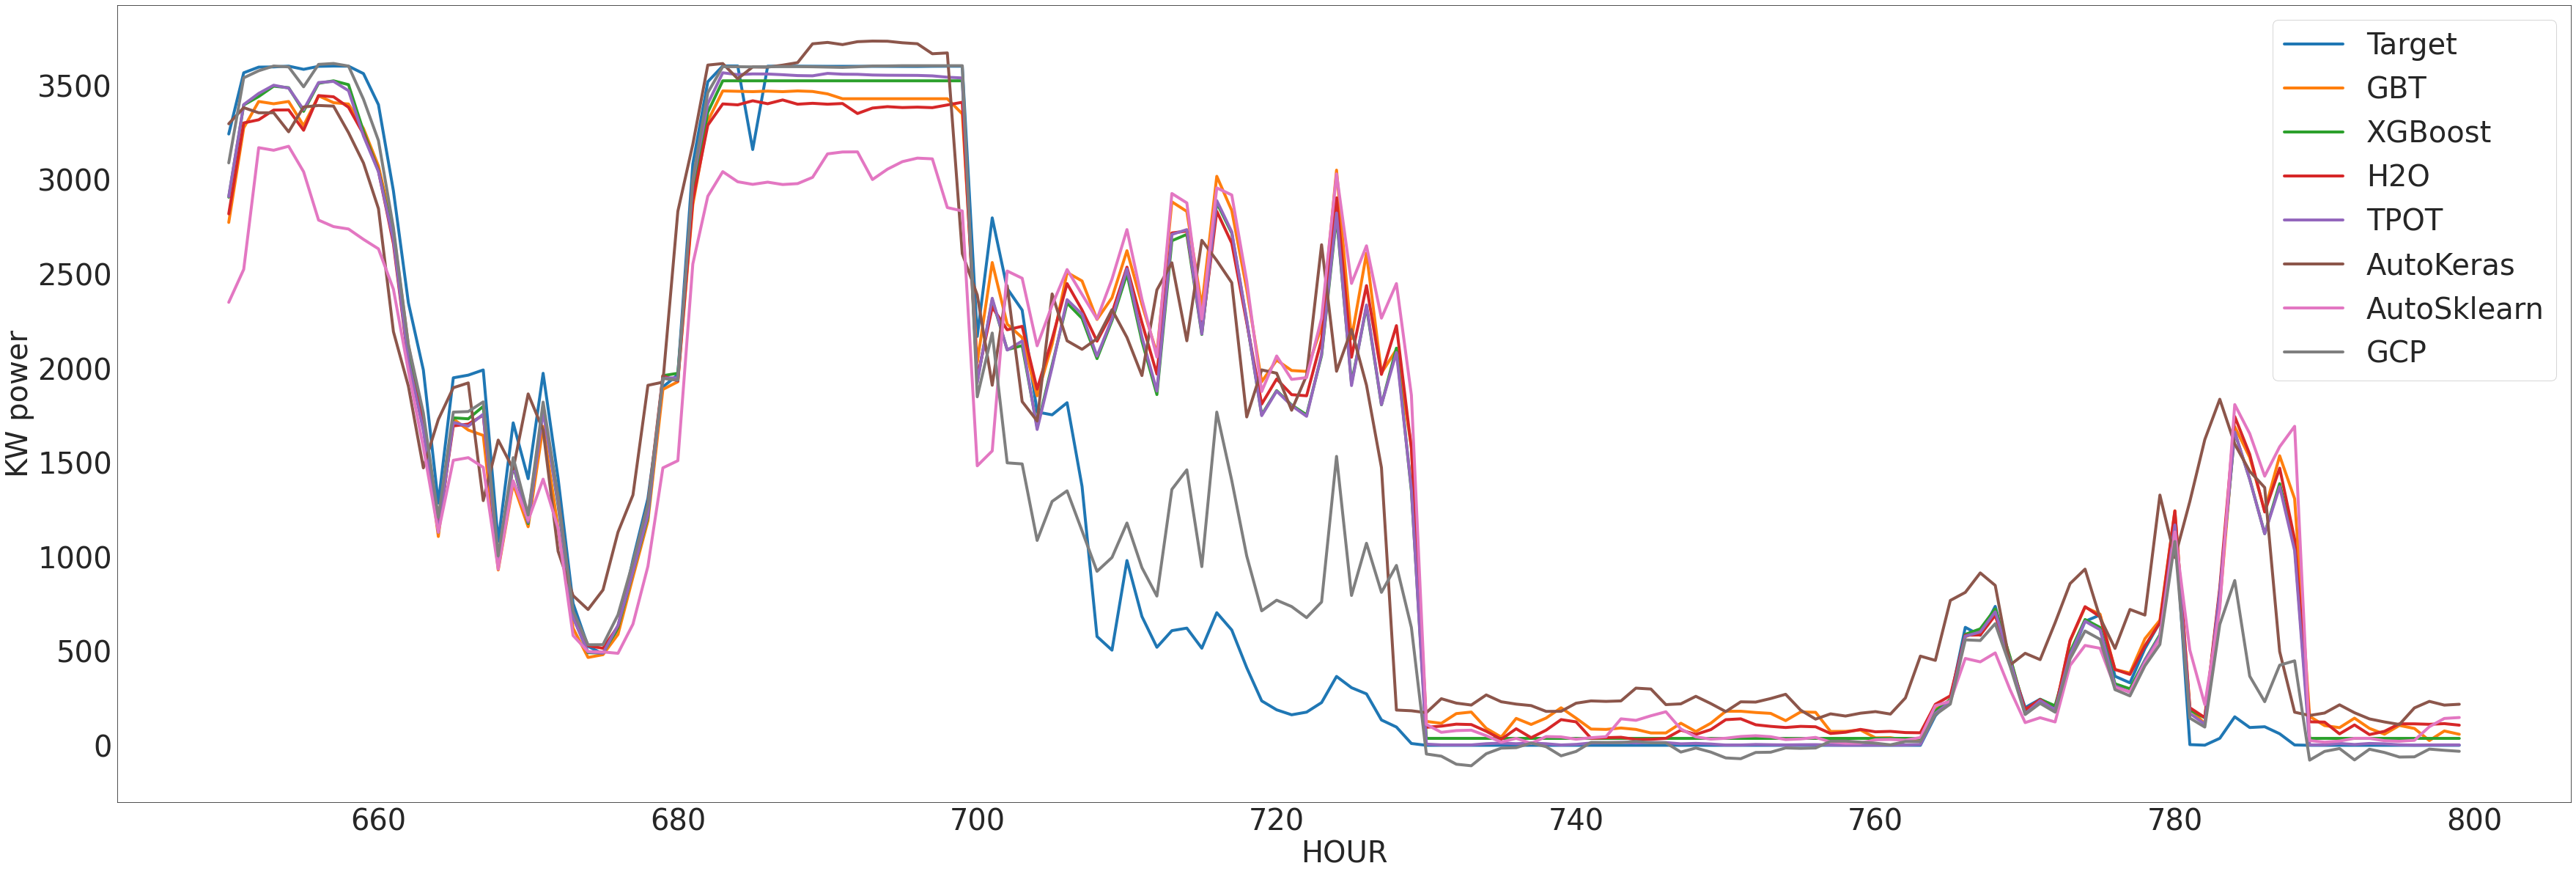

In [49]:
import matplotlib.pyplot as plt

def plot_power_comparison(data, cols_to_plot, cols_to_group, min_granularity, starting_point, ending_point):
  """
  Constructs the comparison plot, grouping according to cols_to_group and min granularity. 
  Also possible to select only smaller part of the complete sequence, for a more clear comparison
  :param data: dataframe containing the test features, predictions, and target variables
  :param columns_to_plot: list of str representing the columns to plot
  :param cols_to_group: list of str to perform grouping on
  :param min_granularity: minimum granularity of aggregation and X-Axis label
  :param starting_point: first point to plot of the sequence
  :param ending_point: last point to plot of the sequence

  :return:
  """
  SMALL_SIZE = 8
  MEDIUM_SIZE = 10
  BIGGER_SIZE = 40

  plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

  data_grouped = data.groupby(cols_to_group).mean().reset_index()

  fig = plt.figure()
  fig.set_figwidth(60)
  fig.set_figheight(20)

  for col in cols_to_plot:
    plt.plot(data_grouped[col][starting_point:ending_point], label=col, linewidth=4)
    plt.ylabel('KW power')
    plt.xlabel(min_granularity)
    plt.legend()
  plt.show()
  
# Rescale the data by
# multiplying each prediction and target column for standard dev
# and subtracting the mean
prediction_col_to_rescale = ['Target','GBT','XGBoost', 'H2O', 'TPOT','AutoKeras', 'AutoSklearn', 'GCP']

data_x_test_results_rescaled = data_x_test_results.copy()
for pred_col in prediction_col_to_rescale:
  data_x_test_results_rescaled[pred_col] = float(scaling_dict['label'][1][1:-1])*data_x_test_results_rescaled[pred_col] + float(scaling_dict['label'][0][1:-1])

cols_to_plot = ['Target','GBT','XGBoost', 'H2O', 'TPOT','AutoKeras', 'AutoSklearn', 'GCP']
cols_to_group = ["month","day","hour"]
min_granularity = "HOUR"
starting_point = 650
ending_point = 800
plot_power_comparison(data_x_test_results_rescaled, cols_to_plot, cols_to_group, min_granularity, starting_point, ending_point)

## Create error dictionaries

In [50]:
def get_evaluation_dictionary(data, y_target, cols_to_evaluate):
  """
  Construct the evaluation dictionary based on RMSE
  :param data: dataframe containing the test features, predictions, and target variables
  :param y_target: actual target column
  :param cols_to_evaluate: columns list to be evaluated
  :return: the evaluation dictionary
  """
  evaluation_rmse_dict = {}
  for col in cols_to_evaluate:
    evaluation_rmse_dict[col] = np.sqrt(mean_squared_error(y_target, data[col]))
  return evaluation_rmse_dict

cols_to_evaluate = ['GBT','XGBoost', 'H2O', 'TPOT','AutoKeras', 'AutoSklearn', 'GCP' ]
dict_standard_scaled_errors = get_evaluation_dictionary(data_x_test_results, data_y_test, cols_to_evaluate)
dict_rescaled_errors = get_evaluation_dictionary(data_x_test_results_rescaled, float(scaling_dict['label'][1][1:-1])*data_y_test + float(scaling_dict['label'][0][1:-1]), cols_to_evaluate)

## Plot error comparison

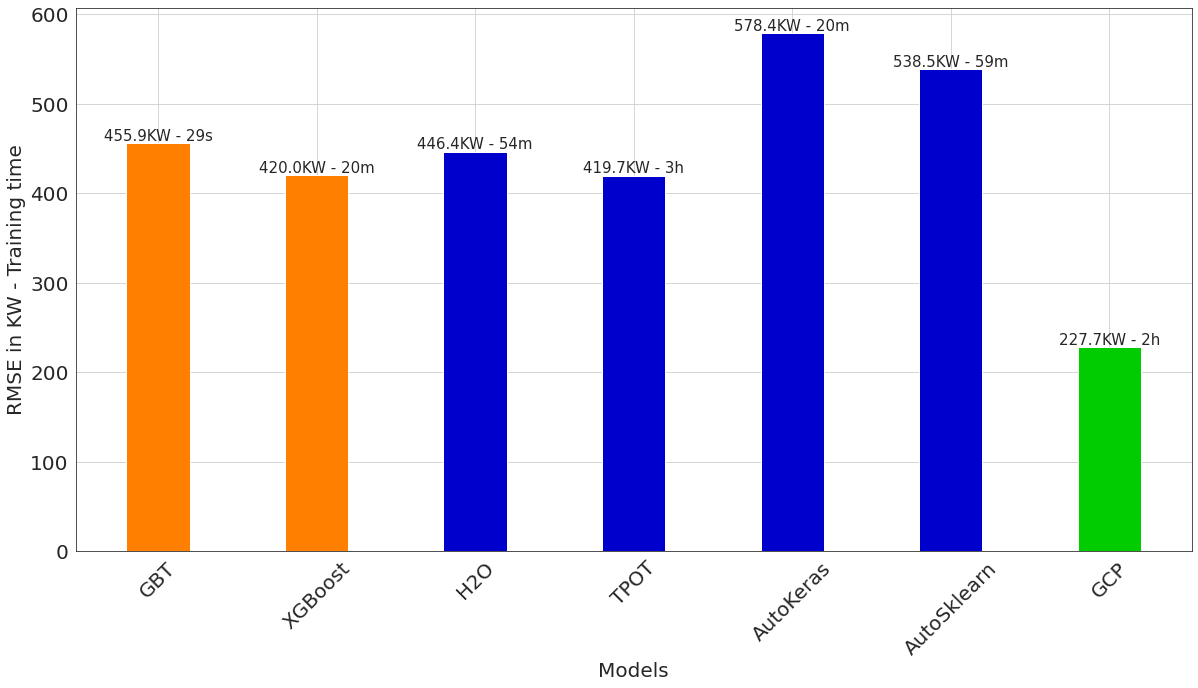

In [51]:
import matplotlib.cm as cm

# Comparison dictionaries
col_list = ['GBT', 'XGBoost','H2O','TPOT','AutoKeras','AutoSklearn','GCP']

execution_times_dict = {
  'GBT': '29s',
  'XGBoost': '20m',
  'H2O': '54m',
  'TPOT': '3h',
  'AutoKeras': '20m',
  'AutoSklearn': '59m',
  'GCP': '2h'
  }

# Creating values to be inserted into the BarPlot
keys = dict_rescaled_errors.keys()
error_values = [dict_rescaled_errors[x] for x in col_list]
execution_times_values = [execution_times_dict[x] for x in col_list]
label_list = []
for index in range(len(error_values)):
  label_list.append(str(np.round(error_values[index],1)) + 'KW' + ' - ' + str(execution_times_values[index]))

# Graphic adjustements and plot creation
colors = [(1, 0.5, 0), (1, 0.5, 0), (0, 0, 0.8) ,(0, 0, 0.8), (0, 0, 0.8), (0, 0, 0.8),(0, 0.8, 0)]

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
size = 20
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('figure', titlesize=size)  # fontsize of the figure title

rectangles = plt.bar(keys, error_values, width = 0.4, color=colors)
for index, rect in enumerate(rectangles):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, label_list[index], ha='center', va='bottom', fontsize=15)
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('RMSE in KW - Training time')
plt.grid()
plt.show()